## Income Classifier Assessment Problem

---
Jason Leppelmeier

09/10/2019


This is a binary classification problem where the goal is to predict the income class ("<=50K" or ">50K"). Train and Test datasets have been provided. 

First, load and inspect the datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
train = pd.read_csv('data/au_train.csv')
test = pd.read_csv('data/au_test.csv')

In [3]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [5]:
train['class'].value_counts()

 <=50K    24720
 >50K      7841
Name: class, dtype: int64

In [6]:
test['class'].value_counts()

 <=50K.    12435
 >50K.      3846
Name: class, dtype: int64

In [7]:
12435/(12435+3846)

0.7637737239727289

A few things stand out about the features in the dataset. Some features are numerical values, like `hours-per-week` or `age`. Other features are categorical, including `workclass` and `country`. One feature, `education` is ordinal. The categories for `education` have a meaningful ranking. Luckily, the categories for `education` seem to already have a field that encodes their order - `education-num`. I will use `education-num`, rather than `education` to get the information about the education. The categorical features will need to be One-Hot encoded. The numerical features will need to be Z-scaled. 

Two things stand out right away about the target classes. First, the strings identifying the target classes in the Test dataset have periods at the end. This will cause a problem with matching these values to the encodings for target classes in the Training dataset. I will drop the .'s before encoding the labels. 

Second, this dataset's target classes are imbalanced. There are about 3 times more examples with income <=50K vs income >50K. This imbalance could create bias in training the classifier and inaccuracy in testing the classifier. In this case, the classifier could be over 75% "accurate" if it always predicts <=50K, but it would be a useless classifier... Usually, this situation is addressed by Oversampling or Undersampling. To make sure the classifier considers all training examples, I will use Oversampling of the minority class. 

---
### Prepare the Dataset

Next, clean the extra periods in the target class, and separate the datasets into features *X* and labels *y*. Also encode the labels.

In [8]:
test['class'] = test['class'].str.replace(r'.','')

X_train = train.iloc[:,0:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,0:-1]
y_test = test.iloc[:,-1]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [9]:
le.classes_

array([' <=50K', ' >50K'], dtype=object)

Explore the relationships between the numerical features. There does not seem to be a risk of multicolinearity - correlations between the numerical features are low. 

In [10]:
X_train.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


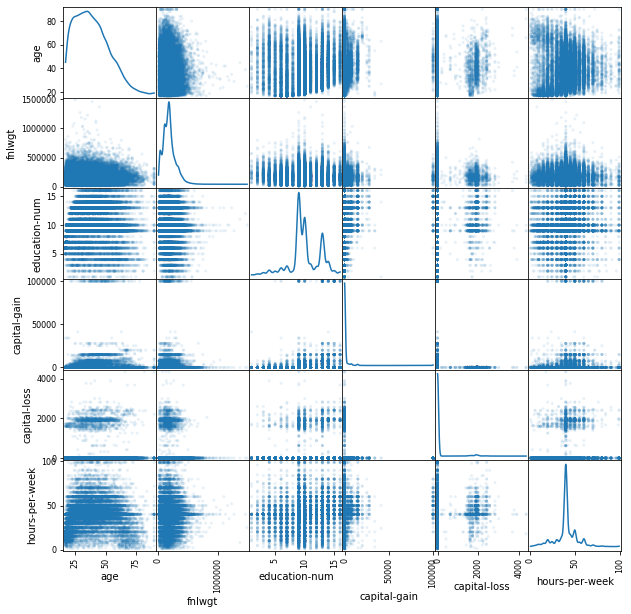

In [11]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt 

scatter_matrix(train, alpha=0.1, figsize=(10,10), diagonal='kde')
plt.show()

Now, apply transformations to One-Hot encode the categorical features and Z-scale the numerical features. Apply feature names to the transformed data.

During the One-Hot encoding, select `drop='first'` to prevent the dummy variable problem. 

In [12]:
categorical_fields = ['workclass','marital-status','occupation', 
                      'relationship', 'race', 'sex', 'native-country']
numerical_fields = ['age','fnlwgt','capital-gain','capital-loss','hours-per-week']

preprocess = make_column_transformer(
    (OneHotEncoder(drop='first'), categorical_fields),
    (StandardScaler(), numerical_fields))

In [13]:
X_train = pd.DataFrame(preprocess.fit_transform(X_train).toarray())
X_test = pd.DataFrame(preprocess.transform(X_test).toarray())

X_train.columns = np.append(preprocess.transformers_[0][1].get_feature_names(),numerical_fields)
X_test.columns = np.append(preprocess.transformers_[0][1].get_feature_names(),numerical_fields)

In [14]:
X_train.head()

,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,x0_ Self-emp-inc,x0_ Self-emp-not-inc,x0_ State-gov,x0_ Without-pay,x1_ Married-AF-spouse,x1_ Married-civ-spouse,...,x6_ Thailand,x6_ Trinadad&Tobago,x6_ United-States,x6_ Vietnam,x6_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.030671,-1.063611,0.148453,-0.21666,-0.035429
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.837109,-1.008707,-0.145920,-0.21666,-2.222153
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.042642,0.245079,-0.145920,-0.21666,-0.035429
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.057047,0.425801,-0.145920,-0.21666,-0.035429
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.775768,1.408176,-0.145920,-0.21666,-0.035429


The Ordinal education fields were dropped from the datasets during transformation. Bring the encoded field, `education-num` back into the dataset.

In [15]:
# now append education-num back to the df's...

X_train['education-num'] = train['education-num']
X_test['education-num'] = test['education-num']

Next, use the SMOTENC algorithm to oversample the minority class. After oversampling, the numbers of each target class should be balanced. 

In [16]:
column_list = X_train.columns

sm = SMOTENC(categorical_features=[1,3,4,5,6,7,8,12])

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = sm.fit_resample(X_test, y_test)

X_train = pd.DataFrame(X_train_resampled)
X_train.columns = column_list
X_test = pd.DataFrame(X_test_resampled)
X_test.columns = column_list

y_train = y_train_resampled
y_test = y_test_resampled

In [17]:
pd.Series(y_train_resampled).value_counts()

1    24720
0    24720
dtype: int64

### Training and Evaluating Classifiers
---

The random forest classifier trains multiple decision trees on subsets of the features. This will work well for the mixed data types. It will also give an initial estimate of the most useful features. 

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=15)

In [19]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Review the accuracy on the Training set for reference. Review the out of sample accuracy on the Testing set as a guage of model performance.

In [20]:
print("Train Set Accuracy: {:04f}".format(rf.score(X_train,y_train)))

Train Set Accuracy: 0.870065


In [21]:
print("Test Set Accuracy: {:04f}".format(rf.score(X_test,y_test)))

Test Set Accuracy: 0.862766


For reference, print the most useful features for the random forest model. 

In [22]:
feature_importances = pd.DataFrame({'Feature': X_train.columns,'Importance': rf.feature_importances_})
feature_importances.sort_values('Importance',ascending=False).iloc[0:25]

,Feature,Importance
9,x1_ Married-civ-spouse,0.201043
84,education-num,0.118059
79,age,0.108573
11,x1_ Never-married,0.101238
83,hours-per-week,0.069422
81,capital-gain,0.067437
30,x3_ Own-child,0.042724
28,x3_ Not-in-family,0.038364
37,x5_ Male,0.033228
31,x3_ Unmarried,0.028027


Create the Confusion Matrix for the Random Forest model. The confusion matrix shows which classes were predicted correctly (True Positives and True Negatives) and also which classes were mispredicted (False Positives and False Negatives).  

In [23]:
y_hat = rf.predict(X_test)
cf = pd.DataFrame(confusion_matrix(y_test, y_hat))
cf.columns = le.inverse_transform(cf.columns)
cf.index = le.inverse_transform(cf.index)
cf

,<=50K,>50K
<=50K,10321,2114
>50K,1299,11136


Create a Receiver Operating Curve (ROC) for the Random Forest model. The ROC curve shows the ratio of True Positives to False Positives. Also calculate the Area Under the Curve (AUC) from the ROC curve. 

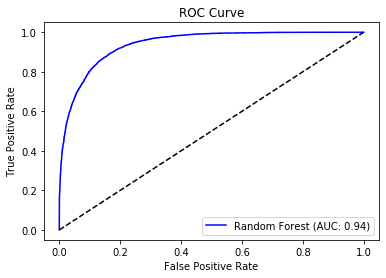

In [24]:
y_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
rf_auc = auc(fpr,tpr)


plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='blue', label='Random Forest (AUC: {:.02f})'.format(rf_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [25]:
print("AUC: {:04f}".format(rf_auc))

AUC: 0.940043


In [26]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=50, gamma=0.01)

In [27]:
svm.fit(X_train, y_train)

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
svm.score(X_train,y_train)

0.8625809061488673

In [29]:
svm.score(X_test,y_test)

0.8499798954563731

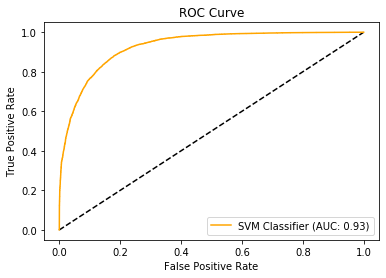

In [30]:
y_pred = svm.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
svm_auc = auc(fpr,tpr)


plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='orange', label='SVM Classifier (AUC: {:.02f})'.format(svm_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [31]:
svm_auc

0.9280424997279783

Create a Confusion Matrix for the SVM model

In [32]:
y_hat = svm.predict(X_test)
cf = pd.DataFrame(confusion_matrix(y_test, y_hat))
cf.columns = le.inverse_transform(cf.columns)
cf.index = le.inverse_transform(cf.index)
cf

,<=50K,>50K
<=50K,10166,2269
>50K,1462,10973


Both models performed reasonably well for a first attempt. The accuracies for the SVM and Random Forest are roughly 85% when tested on a balanced test set. 

The ROC curve shows the relationship between True Positives and False Positives for the models. Completely random results would be expected to follow the dashed line in these ROC plots. Both ROC Curves push up toward the left corner of their graphs, which shows a good number of True Positives vs False Positives. The Area Under the Curve (AUC) is a metric that quantifies the relationship shown in the ROC curve. A theoretically perfect AUC would be 1.0. The AUC's for these classifiers are similar: 0.94 and 0.93 for the Random Forest and SVM respectively. So the Random Forest performed slightly better, but results with both classifiers were similar.

Next steps for improving these models would be to tune the hyperparameters using a systematic approach such as a grid search using cross validation of the training set. Another possible way to improve the models might be to build an ensemble. The datasets could be divided based one some of the identified important features. For example, bins could be made for age ranges or country GDP's. Then separate models could be trained for individuals falling within certain age ranges or countries falling within certain GDP ranges. 
